In [115]:
import re
from textstat import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

print(os.getcwd())

/data/Documents/DataScience/Courses/Dissertation/src/evaluation


# Setup

In [116]:
def analyze_docs_content(content):
    def clean_rst_content(content):
        content = re.sub(r'::[\s\S]*?\n\n', '', content) # code blocks
        content = re.sub(r'.. [a-z]+::.*?\n', '', content) # rst commands
        content = re.sub(r':[a-z]+:`.*?`', '', content) # inline
        content = re.sub(r'`[^`\n]+`_', '', content) # links
        return content
    cleaned_content = clean_rst_content(content)
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(cleaned_content),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(cleaned_content),
        'smog_index': textstat.smog_index(cleaned_content),
        'automated_readability_index': textstat.automated_readability_index(cleaned_content),
        'difficult_words': textstat.difficult_words(cleaned_content),
    }

In [117]:
def analyze_sphinx_docs(docs_source_dir):
    results = {}
    for root, dirs, files in os.walk(docs_source_dir):
        for file in files:
            if file.endswith('.rst'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                results[file] = analyze_docs_content(content)
    return results

In [118]:
def print_results(results):
    for file_path, metrics in results.items():
        print(f"\nAnalysis for {file_path}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value}")

## Analyse PySynthLab Documentation


In [119]:
docs_source_dir = '../../docs/source'
results = analyze_sphinx_docs(docs_source_dir)
print_results(results)


Analysis for api_reference.rst:
  flesch_reading_ease: -46.13
  flesch_kincaid_grade: 21.6
  smog_index: 0.0
  automated_readability_index: 32.2
  difficult_words: 11

Analysis for candidate_generator.rst:
  flesch_reading_ease: -233.77
  flesch_kincaid_grade: 48.1
  smog_index: 0.0
  automated_readability_index: 110.8
  difficult_words: 12

Analysis for config_manager.rst:
  flesch_reading_ease: -121.76
  flesch_kincaid_grade: 32.0
  smog_index: 0.0
  automated_readability_index: 83.7
  difficult_words: 10

Analysis for index.rst:
  flesch_reading_ease: 13.91
  flesch_kincaid_grade: 13.0
  smog_index: 10.5
  automated_readability_index: 33.7
  difficult_words: 12

Analysis for installation.rst:
  flesch_reading_ease: 48.16
  flesch_kincaid_grade: 8.1
  smog_index: 9.4
  automated_readability_index: 15.7
  difficult_words: 20

Analysis for introduction.rst:
  flesch_reading_ease: 7.56
  flesch_kincaid_grade: 17.5
  smog_index: 18.0
  automated_readability_index: 27.2
  difficult_words

In [120]:
avg_scores = {metric: sum(doc[metric] for doc in results.values()) / len(results)
              for metric in next(iter(results.values()))}

print("\nAverage scores across all documents:")
for metric, value in avg_scores.items():
    print(f"  {metric}: {value:.2f}")



Average scores across all documents:
  flesch_reading_ease: -52.06
  flesch_kincaid_grade: 22.92
  smog_index: 7.03
  automated_readability_index: 50.63
  difficult_words: 24.11


In [121]:
df = pd.DataFrame(results)
df.head()

,api_reference.rst,candidate_generator.rst,config_manager.rst,index.rst,installation.rst,introduction.rst,quickstart.rst,synthesis_problem.rst,synthesis_strategy.rst
flesch_reading_ease,-46.13,-233.77,-121.76,13.91,48.16,7.56,42.38,-6.36,-172.52
flesch_kincaid_grade,21.60,48.10,32.00,13.00,8.10,17.50,10.30,16.60,39.10
smog_index,0.00,0.00,0.00,10.50,9.40,18.00,12.30,13.10,0.00
automated_readability_index,32.20,110.80,83.70,33.70,15.70,27.20,18.10,32.10,102.20
difficult_words,11.00,12.00,10.00,12.00,20.00,36.00,60.00,47.00,9.00


In [122]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Document'}, inplace=True)
df_melted = df.melt(id_vars=['Document'], var_name='Metric', value_name='Score')
df.head()

,Document,api_reference.rst,candidate_generator.rst,config_manager.rst,index.rst,installation.rst,introduction.rst,quickstart.rst,synthesis_problem.rst,synthesis_strategy.rst
0,flesch_reading_ease,-46.13,-233.77,-121.76,13.91,48.16,7.56,42.38,-6.36,-172.52
1,flesch_kincaid_grade,21.60,48.10,32.00,13.00,8.10,17.50,10.30,16.60,39.10
2,smog_index,0.00,0.00,0.00,10.50,9.40,18.00,12.30,13.10,0.00
3,automated_readability_index,32.20,110.80,83.70,33.70,15.70,27.20,18.10,32.10,102.20
4,difficult_words,11.00,12.00,10.00,12.00,20.00,36.00,60.00,47.00,9.00


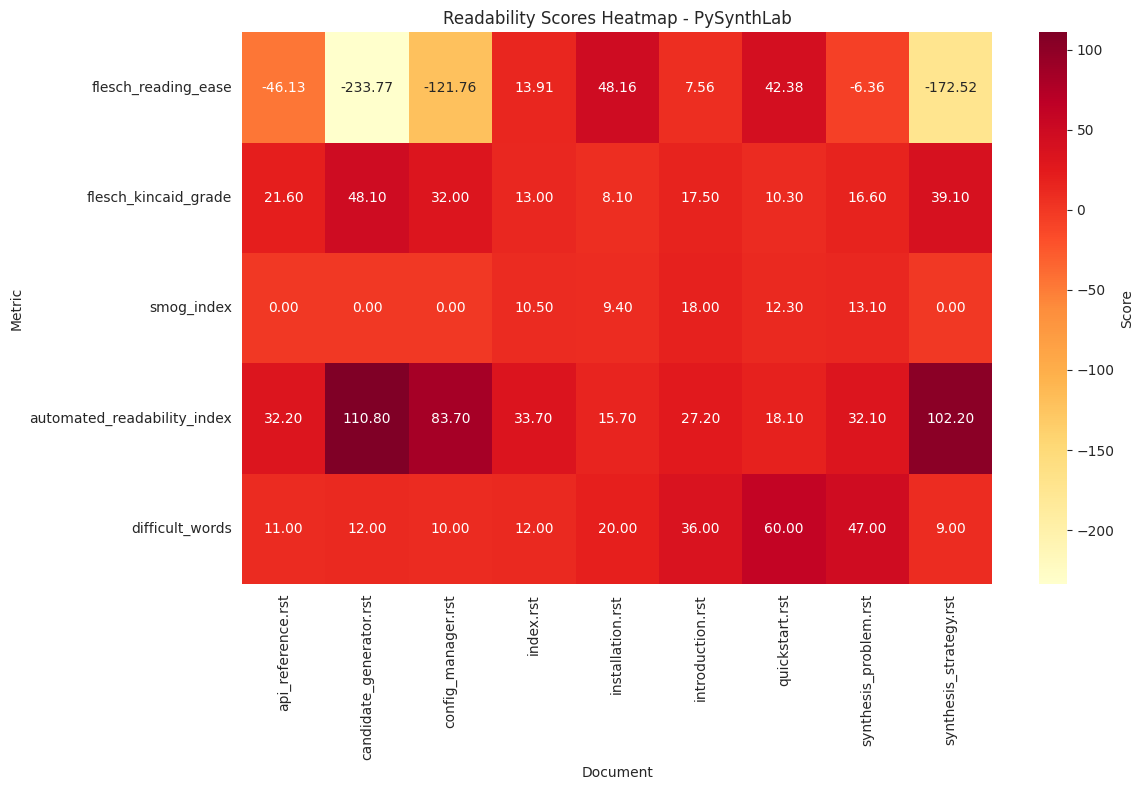

In [123]:
plt.figure(figsize=(12, 8))
s = sns.heatmap(df.set_index('Document'), cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Score'})
s.set(xlabel='Document', ylabel='Metric')
plt.title('Readability Scores Heatmap - PySynthLab')
plt.tight_layout()
plt.savefig('readability_heatmap_pysynthlb.png')
plt.show()

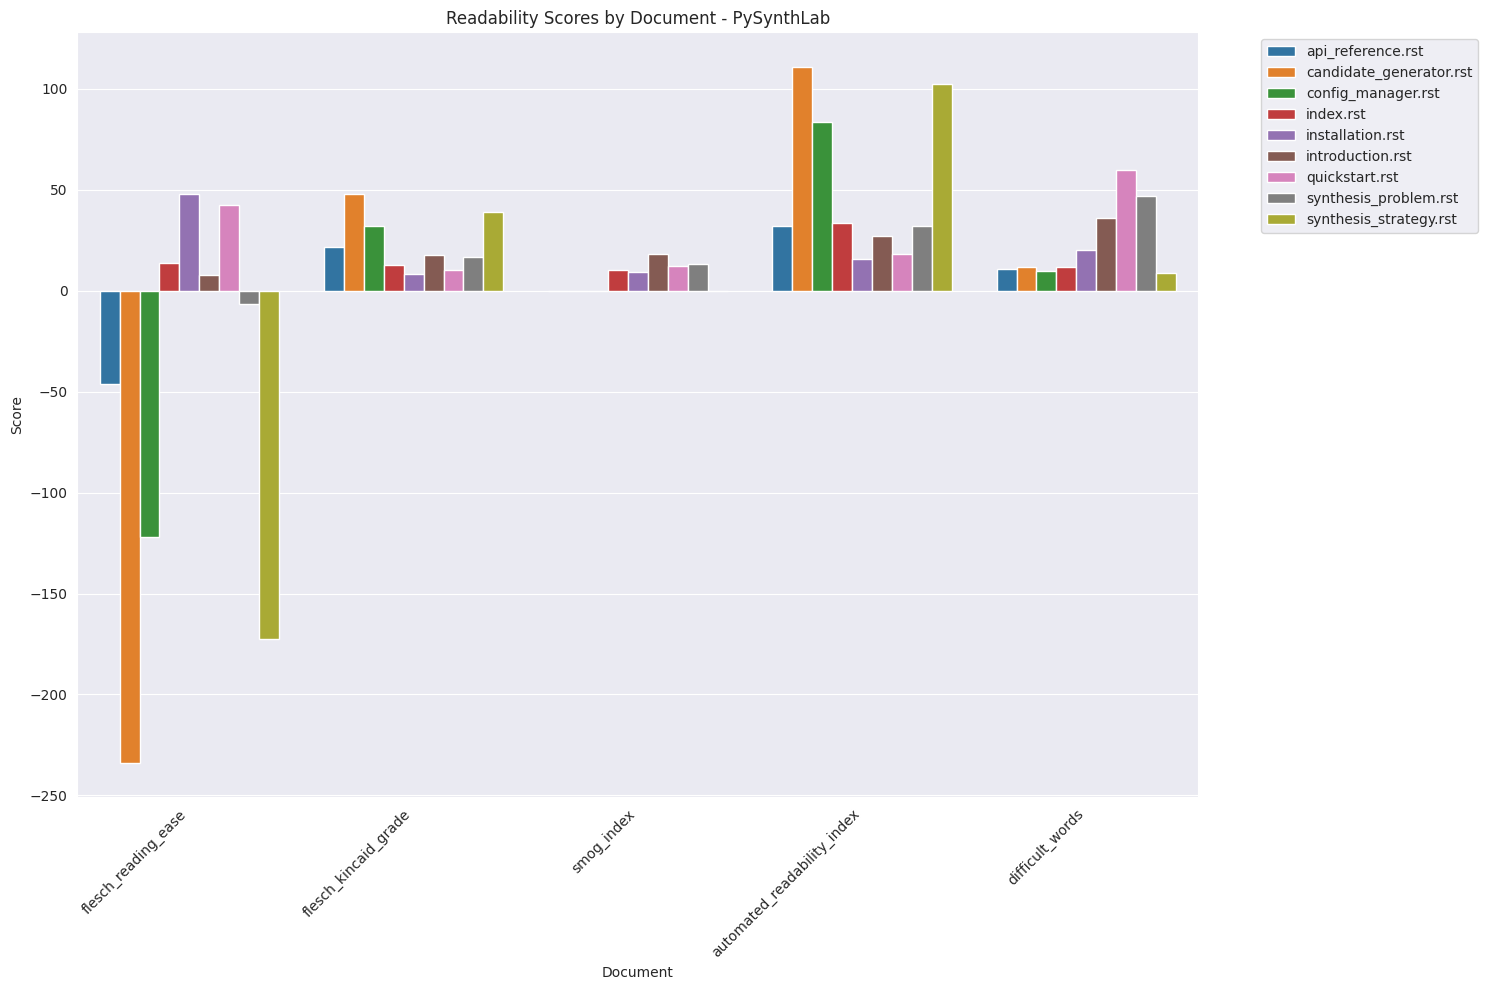

In [124]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Document', y='Score', hue='Metric', data=df_melted)
plt.xticks(rotation=45, ha='right')
plt.title('Readability Scores by Document - PySynthLab')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('readability_barplot_pysynthlab.png')
plt.show()

## Analyse CVC5 Documentation

In [125]:
docs_source_dir = '../../other_solvers/cvc5/docs'
results = analyze_sphinx_docs(docs_source_dir)
print_results(results)


Analysis for genindex.rst:
  flesch_reading_ease: 36.62
  flesch_kincaid_grade: 8.4
  smog_index: 0.0
  automated_readability_index: 26.2
  difficult_words: 1

Analysis for index.rst:
  flesch_reading_ease: 7.11
  flesch_kincaid_grade: 15.6
  smog_index: 14.8
  automated_readability_index: 20.3
  difficult_words: 27

Analysis for options.rst:
  flesch_reading_ease: 56.25
  flesch_kincaid_grade: 9.1
  smog_index: 11.1
  automated_readability_index: 12.8
  difficult_words: 43

Analysis for output-tags.rst:
  flesch_reading_ease: 33.92
  flesch_kincaid_grade: 11.5
  smog_index: 12.5
  automated_readability_index: 17.2
  difficult_words: 16

Analysis for references.rst:
  flesch_reading_ease: -133.6
  flesch_kincaid_grade: 32.4
  smog_index: 0.0
  automated_readability_index: 64.4
  difficult_words: 2

Analysis for resource-limits.rst:
  flesch_reading_ease: 47.93
  flesch_kincaid_grade: 12.3
  smog_index: 13.8
  automated_readability_index: 16.7
  difficult_words: 91

Analysis for skolem

In [126]:
avg_scores = {metric: sum(doc[metric] for doc in results.values()) / len(results)
              for metric in next(iter(results.values()))}

print("\nAverage scores across all documents:")
for metric, value in avg_scores.items():
    print(f"  {metric}: {value:.2f}")


Average scores across all documents:
  flesch_reading_ease: 0.69
  flesch_kincaid_grade: 15.97
  smog_index: 6.96
  automated_readability_index: 38.88
  difficult_words: 18.53


In [127]:
df = pd.DataFrame(results)
df.head()

,genindex.rst,index.rst,options.rst,output-tags.rst,references.rst,resource-limits.rst,skolem-ids.rst,statistics.rst,api.rst,c.rst,...,installation.rst,output_alethe.rst,output_alf.rst,output_dot.rst,output_lfsc.rst,proofs.rst,separation-logic.rst,sets-and-relations.rst,theories.rst,transcendentals.rst
flesch_reading_ease,36.62,7.11,56.25,33.92,-133.6,47.93,75.88,22.07,49.62,37.34,...,-132.59,40.55,63.49,58.28,44.64,59.3,53.41,49.41,-13.61,15.81
flesch_kincaid_grade,8.40,15.60,9.10,11.50,32.4,12.30,3.70,11.90,9.60,14.30,...,32.00,11.00,8.40,8.40,11.50,8.0,10.20,9.70,17.30,16.40
smog_index,0.00,14.80,11.10,12.50,0.0,13.80,0.00,0.00,12.00,15.70,...,0.00,12.50,11.70,10.60,12.80,11.7,13.00,12.50,14.30,15.50
automated_readability_index,26.20,20.30,12.80,17.20,64.4,16.70,37.10,42.60,14.30,27.20,...,92.10,18.50,14.20,10.00,15.80,17.7,26.70,22.90,33.20,24.20
difficult_words,1.00,27.00,43.00,16.00,2.0,91.00,1.00,5.00,16.00,76.00,...,1.00,44.00,59.00,22.00,59.00,29.0,74.00,60.00,38.00,66.00


In [128]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Document'}, inplace=True)
df_melted = df.melt(id_vars=['Document'], var_name='Metric', value_name='Score')
df.head()

,Document,genindex.rst,index.rst,options.rst,output-tags.rst,references.rst,resource-limits.rst,skolem-ids.rst,statistics.rst,api.rst,...,installation.rst,output_alethe.rst,output_alf.rst,output_dot.rst,output_lfsc.rst,proofs.rst,separation-logic.rst,sets-and-relations.rst,theories.rst,transcendentals.rst
0,flesch_reading_ease,36.62,7.11,56.25,33.92,-133.6,47.93,75.88,22.07,49.62,...,-132.59,40.55,63.49,58.28,44.64,59.3,53.41,49.41,-13.61,15.81
1,flesch_kincaid_grade,8.40,15.60,9.10,11.50,32.4,12.30,3.70,11.90,9.60,...,32.00,11.00,8.40,8.40,11.50,8.0,10.20,9.70,17.30,16.40
2,smog_index,0.00,14.80,11.10,12.50,0.0,13.80,0.00,0.00,12.00,...,0.00,12.50,11.70,10.60,12.80,11.7,13.00,12.50,14.30,15.50
3,automated_readability_index,26.20,20.30,12.80,17.20,64.4,16.70,37.10,42.60,14.30,...,92.10,18.50,14.20,10.00,15.80,17.7,26.70,22.90,33.20,24.20
4,difficult_words,1.00,27.00,43.00,16.00,2.0,91.00,1.00,5.00,16.00,...,1.00,44.00,59.00,22.00,59.00,29.0,74.00,60.00,38.00,66.00


In [129]:
df.info()

DataFrame structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 110 entries, Document to transcendentals.rst
dtypes: float64(109), object(1)
memory usage: 4.4+ KB
None

First few rows:
                      Document  genindex.rst  index.rst  options.rst  \
0          flesch_reading_ease         36.62       7.11        56.25   
1         flesch_kincaid_grade          8.40      15.60         9.10   
2                   smog_index          0.00      14.80        11.10   
3  automated_readability_index         26.20      20.30        12.80   
4              difficult_words          1.00      27.00        43.00   

   output-tags.rst  references.rst  resource-limits.rst  skolem-ids.rst  \
0            33.92          -133.6                47.93           75.88   
1            11.50            32.4                12.30            3.70   
2            12.50             0.0                13.80            0.00   
3            17.20            64.4              

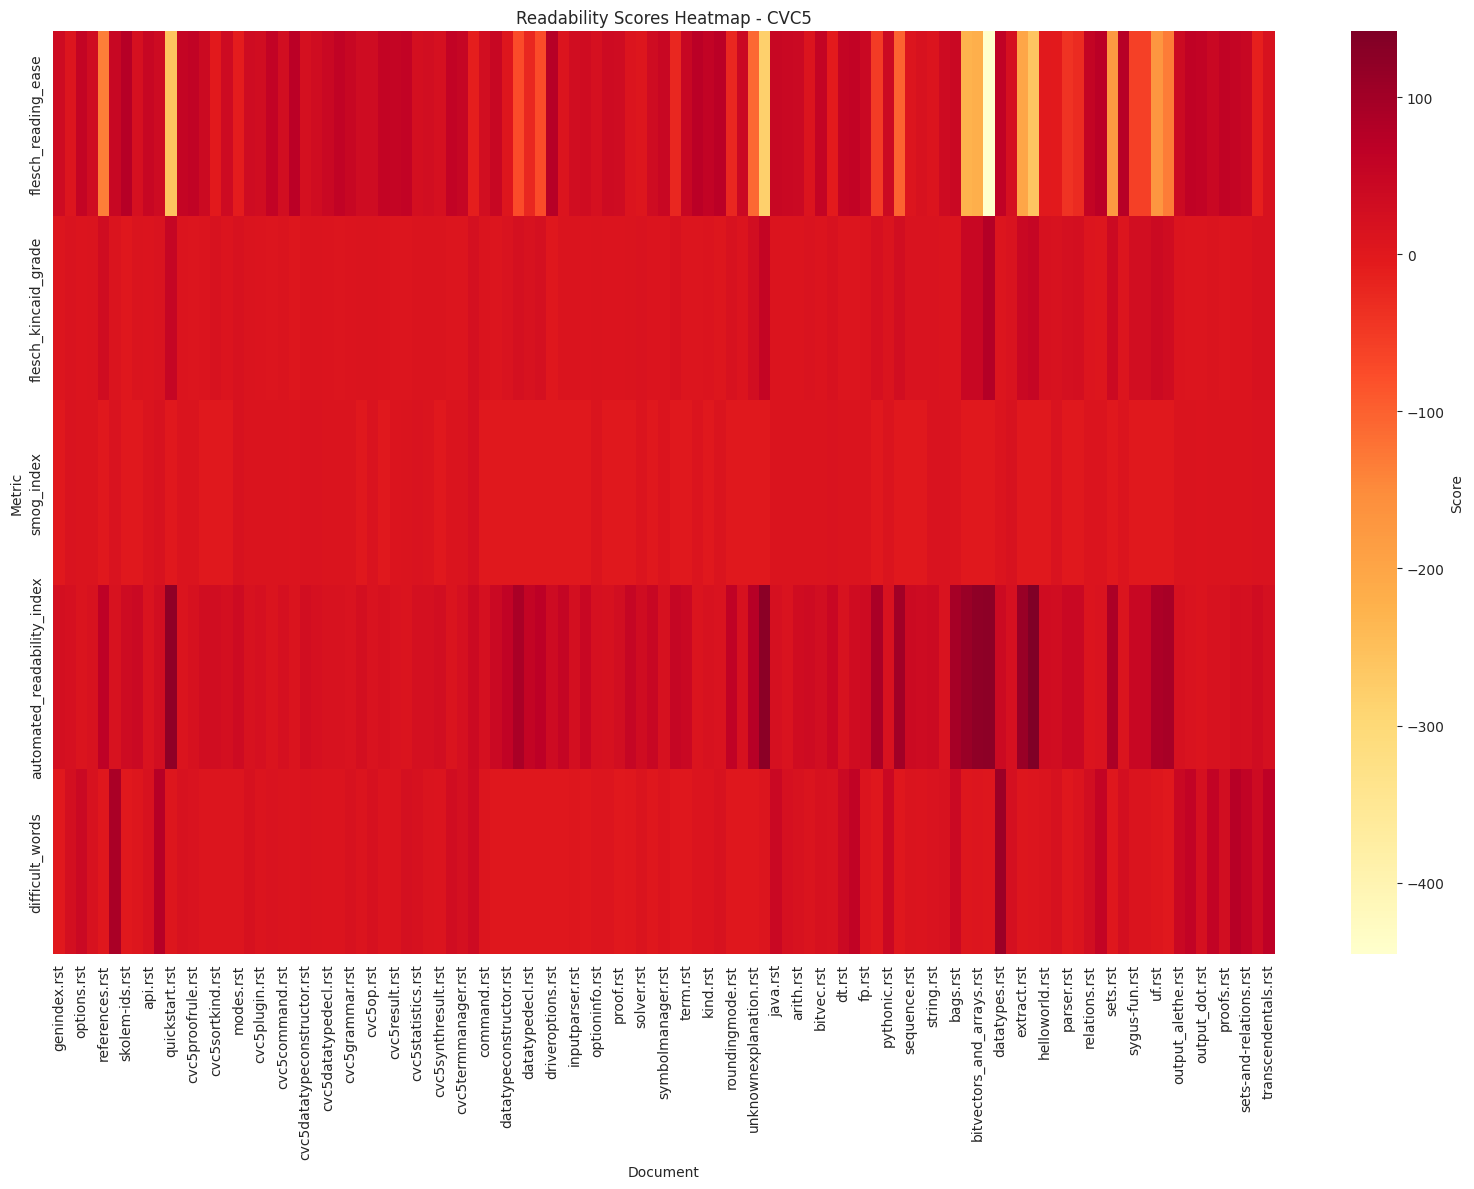

In [135]:
plt.figure(figsize=(16, 12))
s = sns.heatmap(df.set_index('Document'), cmap='YlOrRd', annot=False, fmt='.2f', cbar_kws={'label': 'Score'})
s.set(xlabel='Document', ylabel='Metric')
plt.title('Readability Scores Heatmap - CVC5')
plt.tight_layout()
plt.savefig('readability_heatmap_cvc5.png')
plt.show()